### Importing libraries

In [1]:
import math
import pprint
import datetime
import numpy as np
import pandas as pd
from dateutil import parser
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pandas.tseries.offsets import BDay

In [2]:
%matplotlib inline

### Global variables

In [3]:
DATA_DIR = '../data'
IS_BUSINESS_DAY = BDay().is_on_offset

STARTING_VAULT_AMOUNT = 2000
PP = pprint.PrettyPrinter(depth=6)

### Reading and basic preprocessing of data

In [76]:
raw_asset_a = pd.read_csv(f'{DATA_DIR}/PERTH-AUD_USD_D.csv')

# The prices/numbers are in ',' seperated values.
# raw_asset_a['Price'] = raw_asset_a['Open'].astype(float)
raw_asset_a['Price'] = raw_asset_a['Bid Average'] #.astype(float)

print('Shape is ({}, {})'.format(*raw_asset_a.shape))
raw_asset_a.head()

Shape is (8228, 8)


,Date,Bid High,Ask High,Bid Low,Ask Low,Bid Average,Ask Average,Price
0,2020-08-31,0.7369,0.7374,0.7345,0.7347,0.7357,0.7359,0.7357
1,2020-08-28,0.7315,0.7317,0.7257,0.7258,0.7280,0.7282,0.7280
2,2020-08-27,0.7254,0.7255,0.7230,0.7232,0.7240,0.7242,0.7240
3,2020-08-26,0.7206,0.7208,0.7190,0.7191,0.7196,0.7198,0.7196
4,2020-08-25,0.7180,0.7181,0.7159,0.7164,0.7170,0.7172,0.7170


In [77]:
raw_asset_b = pd.read_csv(f'{DATA_DIR}/PERTH-GOLD_USD_D.csv')

# raw_asset_b = raw_asset_b[]
raw_asset_b['Price'] = raw_asset_b['Bid Average'] #.astype(float)

print('Shape is ({}, {})'.format(*raw_asset_b.shape))
raw_asset_b.head(10)

Shape is (9382, 9)


,Date,Bid High,Ask High,Bid Low,Ask Low,Bid Average,Ask Average,6 Month Gold Lease Rates (%PA),Price
0,2020-08-31,1969.49,1978.19,1954.23,1963.23,1963.76,1972.54,NaN,1963.76
1,2020-08-28,1951.51,1960.51,1923.24,1931.85,1933.34,1942.16,NaN,1933.34
2,2020-08-27,1948.99,1958.10,1935.48,1944.48,1940.86,1949.80,NaN,1940.86
3,2020-08-26,1925.39,1934.14,1912.81,1921.75,1920.41,1929.22,NaN,1920.41
4,2020-08-25,1931.76,1940.84,1921.09,1930.09,1927.79,1936.74,NaN,1927.79
5,2020-08-24,1943.74,1952.77,1927.40,1936.04,1933.81,1942.69,NaN,1933.81
6,2020-08-21,1948.19,1956.93,1930.29,1939.10,1942.61,1951.60,NaN,1942.61
7,2020-08-20,1945.58,1954.32,1923.14,1931.98,1936.51,1945.53,NaN,1936.51
8,2020-08-19,2001.51,2010.22,1982.39,1991.20,1989.23,1998.25,NaN,1989.23
9,2020-08-18,2003.15,2012.12,1976.56,1985.90,1991.84,2001.14,NaN,1991.84


In [78]:
# This will merge both df according to their "Date" column and will
# fill nan in case a date is present in one and absent in other dataframe.
raw_df = raw_asset_a.merge(raw_asset_b, how='outer', left_on='Date', right_on='Date', suffixes=('_a', '_b'))

raw_df['Date'] = pd.to_datetime(raw_df['Date'])

raw_df = raw_df.loc[:, ['Date', 'Price_a', 'Price_b']]
raw_df.columns = ['Date', 'Price_A', 'Price_B']

print('Shape is ({}, {})'.format(*raw_df.shape))
print('Are null values present: {}'.format(raw_df.isna().values.any()))

raw_df.head()

Shape is (9382, 3)
Are null values present: True


,Date,Price_A,Price_B
0,2020-08-31,0.7357,1963.76
1,2020-08-28,0.7280,1933.34
2,2020-08-27,0.7240,1940.86
3,2020-08-26,0.7196,1920.41
4,2020-08-25,0.7170,1927.79


In [79]:
# Will replace the nan values with the last valid observation for that column.
raw_df = raw_df.sort_values(by='Date').reset_index(drop=True)
raw_df = raw_df.ffill(axis=0).sort_values(by='Date').reset_index(drop=True)

print('Shape is ({}, {})'.format(*raw_df.shape))
print('Are null values present: {}'.format(raw_df.isna().values.any()))

raw_df.head()

Shape is (9382, 3)
Are null values present: False


,Date,Price_A,Price_B
0,1991-06-21,0.7650,367.20
1,1991-06-22,0.7645,366.10
2,1991-06-23,0.7645,366.10
3,1991-06-24,0.7628,365.48
4,1991-06-25,0.7650,363.02


### Select Data

In [80]:
start_date = pd.Timestamp('today').floor('D') + pd.Timedelta(-30* 365, unit='D') 
end_date = pd.Timestamp('today').floor('D') + pd.Timedelta(30, unit='D')

df = raw_df[
        (raw_df['Date']>=start_date) & (raw_df['Date']<=end_date)
     ].sort_values(by='Date').reset_index(drop=True)

df.head()

,Date,Price_A,Price_B
0,1991-06-21,0.7650,367.20
1,1991-06-22,0.7645,366.10
2,1991-06-23,0.7645,366.10
3,1991-06-24,0.7628,365.48
4,1991-06-25,0.7650,363.02


### Artificial data

In [81]:
def plot_results (plot_data):
    gs = gridspec.GridSpec(5, 2)

    pl.figure(figsize=(8, 8))
    pl.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=1)

    ax = pl.subplot(gs[0,:]) # row 0, col 0
    plt.title('A Price')
    plt.plot(plot_data['dates'], plot_data['a_price'], color='blue')

    ax = pl.subplot(gs[1, 0]) # row 0, col 1
    plt.title('A buying power')
    plt.plot(plot_data['dates'], plot_data['a_buying_power'], color='blue')

    ax = pl.subplot(gs[1, 1]) # row 0, col 1
    plt.title('A held quantity')
    plt.plot(plot_data['dates'], plot_data['a'], color='blue')

    ax = pl.subplot(gs[2,:]) # row 0, col 0
    plt.title('B Price')
    plt.plot(plot_data['dates'], plot_data['b_price'], color='blue')

    ax = pl.subplot(gs[3, 0]) # row 0, col 1
    plt.title('B buying power')
    plt.plot(plot_data['dates'], plot_data['b_buying_power'], color='blue')

    ax = pl.subplot(gs[3, 1]) # row 0, col 1
    plt.title('B held quantity')
    plt.plot(plot_data['dates'], plot_data['b'], color='blue')

    ax = pl.subplot(gs[4, :]) # row 1, span all columns
    plt.title('Vault Buying Power')
    plt.plot(plot_data['dates'], plot_data['vault_buying_power'], color='blue')


In [82]:
def simulate_model(
    data, 
    ratio_a=0.5, ratio_b=0.5, 
    starting_buying_power=2000, 
    slippage=0.05,
    sell_apr_percentage = 0.01, 
    rebalance_interval_days=7, 
    stop_sell=0.5,
    buying_power_stoploss=0.3
):
    a_prev = data.iloc[0, 1]
    b_prev = data.iloc[0, 2]
    
    slippage_multiplier = (1 - slippage)
    counter = 0
    
    plot_data = {
        'dates': [],
        'vault': [],
        'vault_buying_power': [],
        'a': [],
        'b': [],
        'a_price': [],
        'b_price': [],
        'a_buying_power': [],
        'b_buying_power': []
    }
    
#     1 USD/CNY = a_prev?
    
    
    START_CONFIG = {
        'vault_buying_power': starting_buying_power,
        'a': (ratio_a * starting_buying_power) / a_prev,
        'b': (ratio_b * starting_buying_power) / b_prev,
        'a_buying_power': ratio_a * starting_buying_power,
        'b_buying_power': ratio_b * starting_buying_power
    }
    
    min_balance_allowed_a = (1 - stop_sell) * START_CONFIG['a']
    min_balance_allowed_b = (1 - stop_sell) * START_CONFIG['b']
    
    print('Start with values', START_CONFIG)
    print()
    
    for i in data.index.to_list():
        a = data.iloc[i, 1]
        b = data.iloc[i, 2]

        # calculate old buying power
        old_a_buying_power = START_CONFIG['a_buying_power']
        old_b_buying_power = START_CONFIG['b_buying_power']
        old_buying_power = old_a_buying_power + old_b_buying_power
        
        # calculate new buying power
        new_a_balance = START_CONFIG['a']
        new_b_balance = START_CONFIG['b']
        new_a_buying_power = new_a_balance * a
        new_b_buying_power = new_b_balance * b
        
        # check if the new buygin power has increased; only in which case do we rebalance
        new_buying_power = new_a_buying_power + new_b_buying_power
        
        # now the target buying power should be something that maintains the ratio we 
        # have above.
        target_a_buying_power = new_buying_power * ratio_a
        target_b_buying_power = new_buying_power * ratio_b
        
        START_CONFIG['a_buying_power'] = new_a_buying_power
        START_CONFIG['b_buying_power'] = new_b_buying_power

        # caclulate the change in buying power and how much of the buying power we wish to rebalance
        diff_a_buying_power = abs(new_a_buying_power - old_a_buying_power)
        diff_b_buying_power = abs(new_b_buying_power - old_b_buying_power)
        diff_a_b_buying_power = abs(diff_a_buying_power - diff_b_buying_power)
        buying_power_to_rebalance = diff_a_b_buying_power * sell_apr_percentage
        
        # Rebalance the assets.       
        if (new_a_buying_power < target_a_buying_power):
            # if A has more buying power then we sell `sell_apr_percentage`% of the profits in A and buy B
            new_a_balance -= buying_power_to_rebalance / (a * slippage_multiplier)
            new_b_balance += buying_power_to_rebalance / (b * slippage_multiplier)
        elif (new_b_buying_power < target_b_buying_power):
            # and vice versa
            new_a_balance += buying_power_to_rebalance / (a * slippage_multiplier)
            new_b_balance -= buying_power_to_rebalance / (b * slippage_multiplier)
        
        # check if we are hitting our stop sell or not...
        stopsell_hit = new_a_balance <= min_balance_allowed_a or new_b_balance <= min_balance_allowed_b
        
        # check if we are trading in the right day or not
        invalid_trading_day = i % rebalance_interval_days != 0
        
        # check if there is no change in the buying power
        no_change_in_buying_power = new_buying_power < old_buying_power
        
        # check if we are selling too much of a particular asset. Ideally we should make 
        # sure that we buy/sell as much so that the
        # underlying does not get fully sold off.
        selling_too_much = new_a_balance <= 0 or new_b_balance <= 0
        
        # don't do anything if any of the following conditions are being hit
        if (invalid_trading_day or stopsell_hit or no_change_in_buying_power or selling_too_much):
            plot_data['dates'].append(df.loc[i, 'Date'])
            plot_data['vault_buying_power'].append(new_buying_power)
            plot_data['a'].append(START_CONFIG['a'])
            plot_data['b'].append(START_CONFIG['b'])
            plot_data['a_price'].append(a)
            plot_data['b_price'].append(b)
            plot_data['a_buying_power'].append(new_a_buying_power)
            plot_data['b_buying_power'].append(new_b_buying_power)
            
            if (stopsell_hit and not no_change_in_buying_power and not invalid_trading_day):
                print('Vault triggered a trade but was cancelled because the stop sell was hit')
                
            if (selling_too_much and not no_change_in_buying_power and not invalid_trading_day):
                print('Vault triggered a trade but was cancelled because we\'d have fully sold one asset')
                
            continue
            
        # Check if our stop loss has been hit or not. in which case, we bail..
        if (new_buying_power - starting_buying_power) / starting_buying_power <= buying_power_stoploss * -1: 
            print('Breaking')
            break
    
        # Recalculate the new vault's buying power
        counter += 1
        START_CONFIG['a'] = new_a_balance
        START_CONFIG['b'] = new_b_balance
        START_CONFIG['vault_buying_power'] = new_buying_power
        
        plot_data['dates'].append(df.loc[i, 'Date'])
        plot_data['vault_buying_power'].append(new_buying_power)
        plot_data['a'].append(START_CONFIG['a'])
        plot_data['b'].append(START_CONFIG['b'])
        plot_data['a_price'].append(a)
        plot_data['b_price'].append(b)
        plot_data['a_buying_power'].append(new_a_buying_power)
        plot_data['b_buying_power'].append(new_b_buying_power)

        a_prev, b_prev = a, b
        
    print("finished with %d rebalances" % counter)
    print("final buying power of the vault is %d" % (new_buying_power))
        
    return plot_data, START_CONFIG

Start with values {'vault_buying_power': 2000, 'a': 1307.18954248366, 'b': 2.7233115468409586, 'a_buying_power': 1000.0, 'b_buying_power': 1000.0}

Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop sell was hit
Vault triggered a trade but was cancelled because the stop s

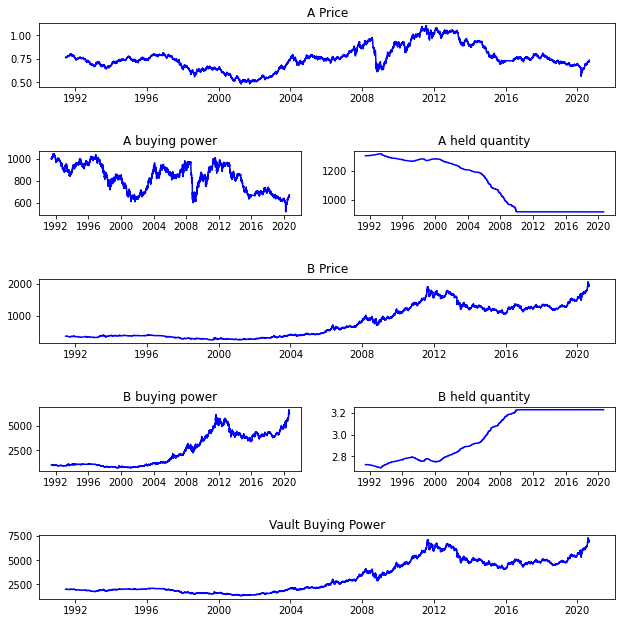

In [85]:
## USD and GOLD with a 50-50 ratio and slippage of 5% and 7 day rebalance interval
results, config = simulate_model(
    df,
    ratio_a=0.5,
    ratio_b=0.5, 
    starting_buying_power=2000,
    slippage=0.01,
    sell_apr_percentage=0.1,
    rebalance_interval_days=7,
    stop_sell=0.3,
    buying_power_stoploss=0.4
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

Start with values {'vault_buying_power': 2000, 'a': 151.03002476892405, 'b': 0.11524162711958162, 'a_buying_power': 1000.0, 'b_buying_power': 1000.0}

finished with 292 rebalances
final buying power of the vault is 2250
Ending with values
{'a': 213.5731931860495,
 'a_buying_power': 1523.1612991642678,
 'b': 0.06780929430357778,
 'b_buying_power': 727.2580718705868,
 'vault_buying_power': 2259.1007185832}



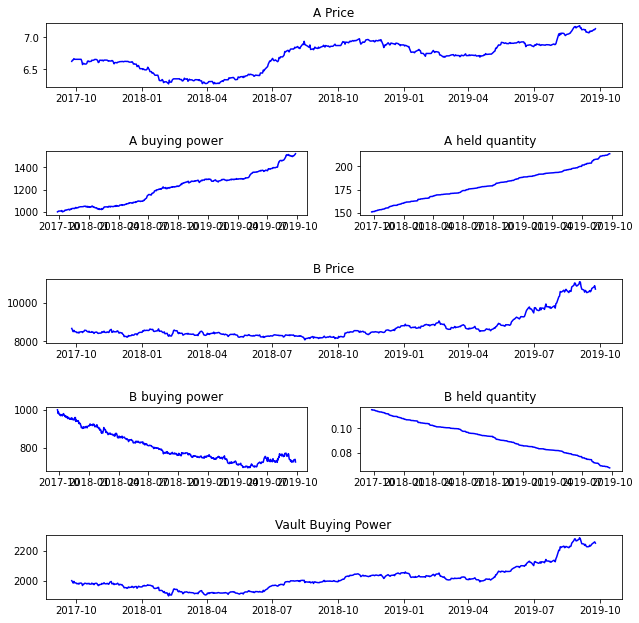

In [15]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 1 day rebalance interval; but selling 50% of 
# the appreciated side instead of 1%
results, config = simulate_model(
    df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=1,
    sell_apr_percentage=0.5
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

Start with values {'vault_buying_power': 2000, 'a': 151.03002476892405, 'b': 0.11524162711958162, 'a_buying_power': 1000.0, 'b_buying_power': 1000.0}

finished with 292 rebalances
final buying power of the vault is 2250
Ending with values
{'a': 213.5731931860495,
 'a_buying_power': 1523.1612991642678,
 'b': 0.06780929430357778,
 'b_buying_power': 727.2580718705868,
 'vault_buying_power': 2259.1007185832}



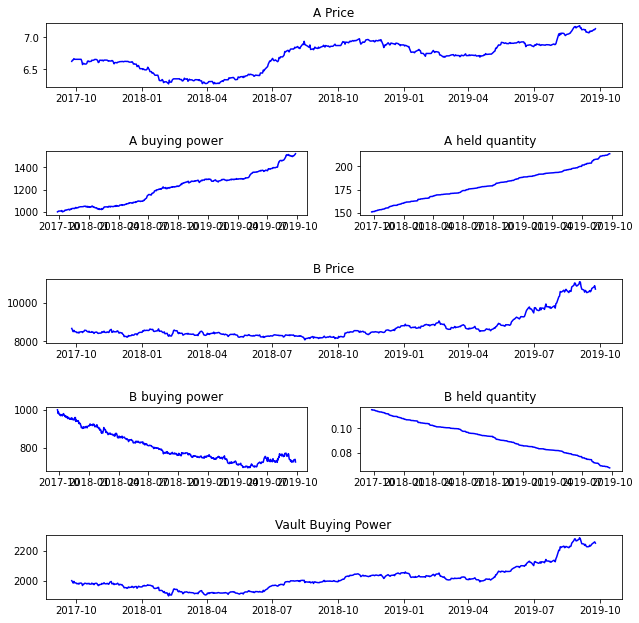

In [16]:
# USD and GOLD with a 50-50 ratio and slippage of 5% and 1 day rebalance interval; but selling 50% of 
# the appreciated side instead of 1%
results, config = simulate_model(
    df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    rebalance_interval_days=1,
    sell_apr_percentage=0.5
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

# eventually we run out of one side of asset because we sell too much; 
# so we should ideally avoid this scenario..

Start with values {'vault_buying_power': 2000, 'a': 151.03002476892405, 'b': 0.11524162711958162, 'a_buying_power': 1000.0, 'b_buying_power': 1000.0}

finished with 40 rebalances
final buying power of the vault is 2313
Ending with values
{'a': 151.03002476892405,
 'a_buying_power': 1077.1159306470126,
 'b': 0.11524162711958162,
 'b_buying_power': 1235.9722129388688,
 'vault_buying_power': 2310.621494686471}



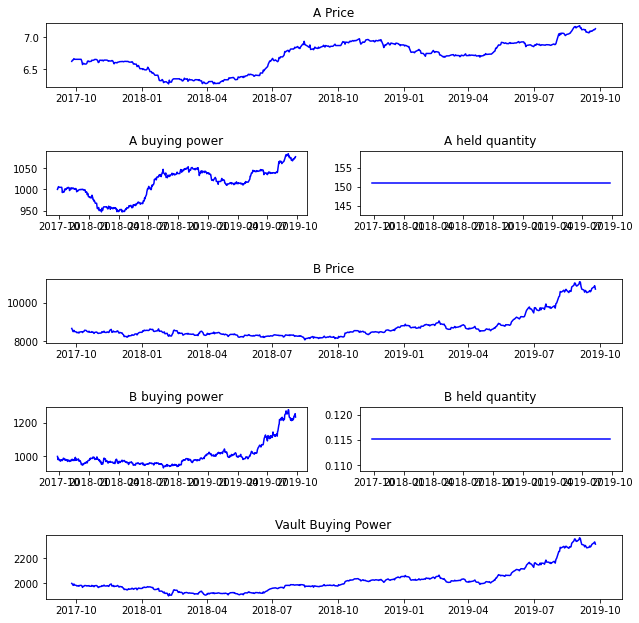

In [17]:
# USD and GOLD with a 50-50 ratio with no rebalancing
results, config = simulate_model(
    df,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT,
    slippage=0.05,
    sell_apr_percentage=0
)

print("Ending with values")
PP.pprint(config)
print()
plot_results(results)

### TODO

In [ ]:
# With one appreciating asset and one depreciating asset. The net result is on the positive.
results, config = simulate_model(
    appreciating_asset,
    depreciating_asset,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT
)

plot_results(results)

In [ ]:
# With two depreciating assets. Really nothing we can do here. the
# net loss in the vault is the averaged loss; Which shows the importance of
# choosing two assets that are hedges of each other...

results, config = simulate_model(
    depreciating_asset,
    depreciating_asset,
    0.5,
    0.5, 
    STARTING_VAULT_AMOUNT
)

plot_results(results)